<a href="https://colab.research.google.com/github/chriswmann/kaggle-house-price-regression/blob/master/House_Prices_Prediction_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
cwd = os.getcwd()
if cwd == '/kaggle/working' or cwd == '/content':
    !pip install --upgrade numpy pandas plotly
import multiprocessing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, randint, uniform
import datetime

def time_now(path_format=True):
    if path_format:
        fmt_str = '%Y%m%d_%H%M%S'
    else:
        fmt_str = '%H:%M:%S'
    return datetime.datetime.now().strftime(fmt_str)
     
now = time_now()

if cwd == '/kaggle/working':
    kaggle = True
    %matplotlib inline
    train_data_path = os.path.join('../input/','train.csv')
    test_data_path = os.path.join('../input/','test.csv')
elif cwd == '/content':
    # stuff to get data
    from google.colab import drive
    from google.colab import auth
    drive.mount('/gdrive')
    drive_path = '/gdrive/My Drive/Colab Notebooks/kaggle/house_price_regression'
    submission_path = os.path.join(drive_path, 'output/')
    train_data_path = os.path.join(drive_path, 'input/house-prices-advanced-regression-techniques/','train.csv')
    test_data_path = os.path.join(drive_path, 'input/house-prices-advanced-regression-techniques/','test.csv')
else:
    kaggle = False
    train_data_path = os.path.join('input/','train.csv')
    test_data_path = os.path.join('input/','test.csv')
    submission_path = 'output/'

sns.set_style("darkgrid")

nthreads = multiprocessing.cpu_count() - 1

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.16.3)
Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.2)
     |████████████████████████████████| 41.2MB 1.2MB/s 
  Found existing installation: plotly 3.6.1
    Uninstalling plotly-3.6.1:
      Successfully uninstalled plotly-3.6.1
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print(train.shape, test.shape)

(1460, 81) (1459, 80)


In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
y = train.SalePrice
y_log = np.log1p(y)

In [5]:
print(train.describe(include=['number']).loc[['min','max','mean', 'std']].T.sort_values('mean'))

                   min       max           mean           std
BsmtHalfBath       0.0       2.0       0.057534      0.238753
HalfBath           0.0       2.0       0.382877      0.502885
BsmtFullBath       0.0       3.0       0.425342      0.518911
Fireplaces         0.0       3.0       0.613014      0.644666
KitchenAbvGr       0.0       3.0       1.046575      0.220338
FullBath           0.0       3.0       1.565068      0.550916
GarageCars         0.0       4.0       1.767123      0.747315
PoolArea           0.0     738.0       2.758904     40.177307
BedroomAbvGr       0.0       8.0       2.866438      0.815778
3SsnPorch          0.0     508.0       3.409589     29.317331
OverallCond        1.0       9.0       5.575342      1.112799
LowQualFinSF       0.0     572.0       5.844521     48.623081
OverallQual        1.0      10.0       6.099315      1.382997
MoSold             1.0      12.0       6.321918      2.703626
TotRmsAbvGrd       2.0      14.0       6.517808      1.625393
ScreenPo

In [6]:
objects_df = train.select_dtypes(include=object)
for col in objects_df.columns:
    print(f'{col:<14}', train[col].unique())

MSZoning       ['RL' 'RM' 'C (all)' 'FV' 'RH']
Street         ['Pave' 'Grvl']
Alley          [nan 'Grvl' 'Pave']
LotShape       ['Reg' 'IR1' 'IR2' 'IR3']
LandContour    ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities      ['AllPub' 'NoSeWa']
LotConfig      ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope      ['Gtl' 'Mod' 'Sev']
Neighborhood   ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1     ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2     ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
BldgType       ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle     ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle      ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl       ['CompShg' 'WdShngl' 'Metal' 'Wd

skew=0.12122191311528363


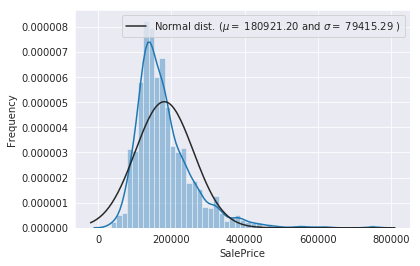

In [7]:
sns.distplot(y, fit=norm)
mu, sigma = norm.fit(y)
plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
print('skew={}'.format(skew(y_log)))

In [0]:
# define a function to produce plots

def box_plot(feature, label='SalePrice', data=train):
    data = data.sort_values(by=label)

    plt.figure(figsize=(16,6))
    ax = sns.boxplot(x=feature, y=label, data=data)
    plt.xlabel(f'{feature}', fontsize=12)
    plt.ylabel(f'{label}', fontsize=12)
    plt.title(f'Distribution of {feature} with {label}', fontsize=15)
    xticks = ax.get_xticks()
    if len(xticks) > 500:
        plt.xticks(rotation=45)
        ax.set(xticks=xticks[0::100])
    elif len(xticks) > 50:
        plt.xticks(rotation=45)
        ax.set(xticks=xticks[0::5])
    plt.show()
    
    plt.figure(figsize=(16,6))
    ax = sns.countplot(x=feature, data=data)
    plt.xlabel(f'{feature}', fontsize=12)
    plt.ylabel(f'{label}', fontsize=12)
    plt.title(f'Sample counts of {feature} with {label}', fontsize=15)
    xticks = ax.get_xticks()
    if len(xticks) > 500:
        plt.xticks(rotation=45)
        ax.set(xticks=xticks[0::100])
    elif len(xticks) > 50:
        plt.xticks(rotation=45)
        ax.set(xticks=xticks[0::5])
    plt.show()

In [0]:
run_plots = 0
if run_plots:
    for col in train.drop(['Id', 'SalePrice'], axis=1).columns:
        box_plot(col)

In [0]:
def outlier_plots(data=train, cols=None, before=True):
    if before:
        suptitle = 'Before'
        colour = 'c'
    else:
        suptitle = 'After'
        colour = 'grey'
    fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))
    fig.suptitle(suptitle, fontsize=20)
    axes = np.ravel(axes)
    cols = cols
    for i, c in zip(range(len(cols)), cols):
        train.plot.scatter(ax=axes[i], x=c, y='SalePrice', sharey=True, colorbar=False, c=colour)

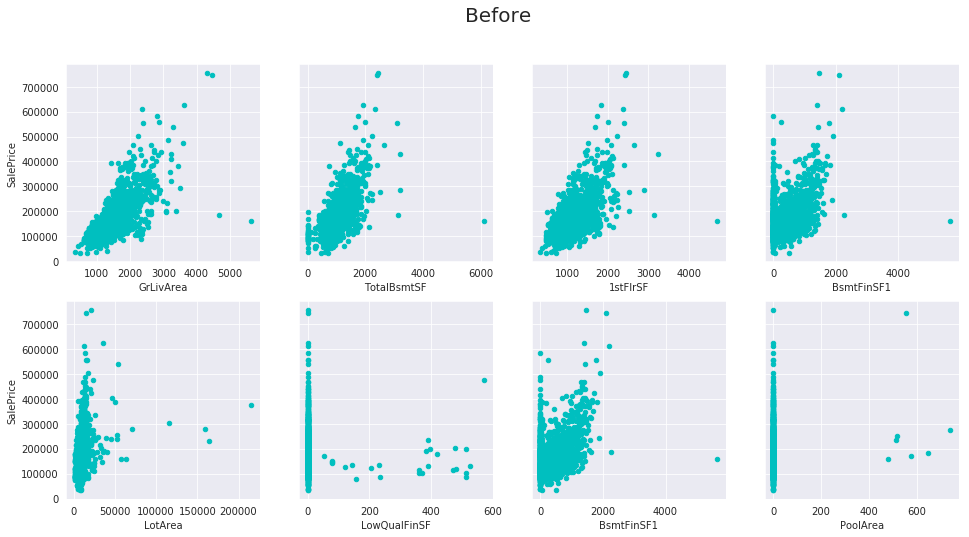

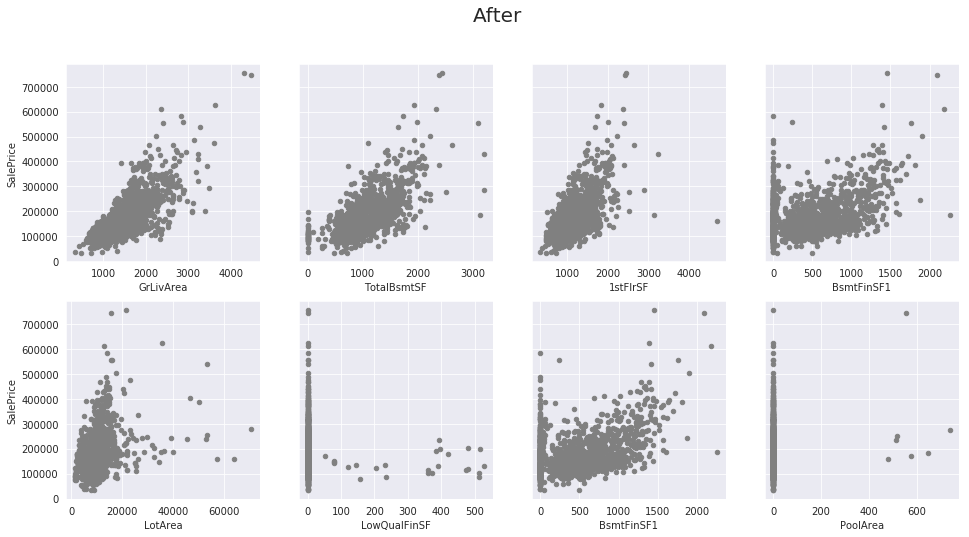

In [11]:
col_names = ['GrLivArea','TotalBsmtSF',
             '1stFlrSF','BsmtFinSF1',
             'LotArea','LowQualFinSF',
             'BsmtFinSF1', 'PoolArea']
outlier_plots(data=train, cols=col_names, before=True)

# fill outliers
outlier_GrLivArea = train.GrLivArea > 4500
train.loc[outlier_GrLivArea, 'GrLivArea'] = train.GrLivArea[train['GrLivArea'] < 4500].median()

outlier_LotArea = train.LotArea > 100000
train.loc[outlier_LotArea, 'LotArea'] = train.LotArea[train['LotArea'] < 100000].median()

outlier_TotalBsmtSF = train.TotalBsmtSF > 6000
train.loc[outlier_TotalBsmtSF, 'TotalBsmtSF'] = train.TotalBsmtSF[train['TotalBsmtSF'] < 6000].median()

outlier_LowQualFinSF = train.LowQualFinSF > 560
train.loc[outlier_LowQualFinSF, 'LowQualFinSF'] = train.LowQualFinSF[train['LowQualFinSF'] < 560].median()

outlier_BsmtFinSF1 = train.BsmtFinSF1 > 4000
train.loc[outlier_BsmtFinSF1, 'BsmtFinSF1'] = train.BsmtFinSF1[train['BsmtFinSF1'] < 4000].median()

outlier_plots(data=train, cols=col_names, before=False)

In [12]:
print(test.GarageArea.iloc[666], test.GarageType.iloc[666], test.GarageCars.iloc[666])

360.0 Detchd 1.0


In [13]:
detached_garages = test[test.GarageType == 'Detchd']
garage_area_mask = detached_garages.GarageArea.between(350, 370)
detached_garages = detached_garages[garage_area_mask]
detached_garages[['GarageQual', 'GarageCond',
                 'GarageFinish', 'GarageYrBlt']]

,GarageQual,GarageCond,GarageFinish,GarageYrBlt
81,TA,TA,Unf,1950.0
129,TA,TA,Unf,1975.0
157,TA,TA,Unf,1971.0
357,TA,TA,Unf,1930.0
502,TA,TA,Unf,1975.0
655,TA,TA,Unf,1924.0
666,NaN,NaN,NaN,NaN
739,TA,TA,Unf,2001.0
754,TA,TA,RFn,1934.0
825,TA,TA,Unf,1974.0


In [0]:
# The test example with ID 666 has GarageArea, GarageCars, and GarageType 
# but none of the other fields, so use the mode and median to fill them in.
test.loc[666, "GarageQual"] = 'TA'
test.loc[666, "GarageCond"] = 'TA'
test.loc[666, "GarageFinish"] = 'Unf'
test.loc[666, "GarageYrBlt"] = 1962

# The test example 1116 only has GarageType but no other information. We'll 
# assume it does not have a garage.
test.loc[1116, "GarageType"] = np.nan

In [15]:
# There's a house with an invalid GarageYrBlt of 2207.  As the
# YearBuilt is 2006, we'll assume the GarageYrBlt is actually 2007
print(test[test['GarageYrBlt'] > 2010].GarageYrBlt)
print(test[test['GarageYrBlt'] > 2010].YearBuilt)
test.loc[test['GarageYrBlt'] > 2010, 'GarageYrBlt'] = 2007

1132    2207.0
Name: GarageYrBlt, dtype: float64
1132    2006
Name: YearBuilt, dtype: int64


## Preprocessing

In [16]:
all_data = train.append(test, sort=False).reset_index(drop=True)
all_data.shape

(2919, 81)

### Deal with NaNs

In [0]:
def nan_info(df):
    # Check the dfing data types
    print(f'Unique dtypes: {df.dtypes.unique()}\n')

    # Check the dfing data for nans
    print(f'NaN count per feature:\n{df.isnull().sum()[df.isnull().sum() > 0]}\n')

    # For reference, print the number of elements in df
    num_vals = df.shape[0] * df.shape[1]
    print(f'Total elements in df: {num_vals}\n')

    # Count the null values in df
    num_nulls = df.isnull().sum().sum()
    print(f'Null values in df: {num_nulls}\n')

    # percentage null values
    print(f'Percentage null values: {(num_nulls / num_vals) * 100:3.1f}%')

In [18]:
nan_info(all_data)

Unique dtypes: [dtype('int64') dtype('O') dtype('float64')]

NaN count per feature:
MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       158
GarageYrBlt      158
GarageFinish     158
GarageCars         1
GarageArea         1
GarageQual       158
GarageCond       158
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
SalePrice       1459
dtype: int64

Total elements in df: 236439

Null values in df: 15421

Percentage null values: 6.5%


In [0]:
# fillna with 0
cols = ['GarageArea', 'GarageCars', 'GarageFinish', 'MasVnrArea', 
        'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
for c in cols:
    all_data[c].fillna(0, inplace=True)

# fillna with 'None'
cols = ['BsmtQual','BsmtCond','KitchenQual','FireplaceQu','GarageType','GarageQual','GarageCond',
        'PoolQC','BsmtFinType1','BsmtFinType2','BsmtExposure','MasVnrType']
for c in cols:
    all_data[c].fillna('None', inplace=True)

# fillna with other 
all_data.loc[all_data['GarageYrBlt'].isnull(),'GarageYrBlt'] = all_data.loc[all_data['GarageYrBlt'].isnull(),'YearBuilt']

# fillna with group median
all_data['LotFrontage'] = all_data.groupby(pd.qcut(all_data['LotArea'], 10))['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [0]:
for i, t in all_data.loc[:, all_data.columns != 'SalePrice'].dtypes.iteritems():
    if t == object:
        all_data[i].fillna(all_data[i].mode()[0], inplace=True)
    else:
        all_data[i].fillna(all_data[i].median(), inplace=True)

In [21]:
nan_info(all_data)

Unique dtypes: [dtype('int64') dtype('O') dtype('float64')]

NaN count per feature:
SalePrice    1459
dtype: int64

Total elements in df: 236439

Null values in df: 1459

Percentage null values: 0.6%


### Create new features

In [0]:
all_data['_OverallQualCond'] = all_data[['OverallQual', 'OverallCond']].mean(axis=1)
all_data['_TotalSF'] = all_data[['TotalBsmtSF', 'GrLivArea', '1stFlrSF', '2ndFlrSF']].sum(axis=1)
all_data['_PorchArea'] = all_data[['OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']].sum(axis=1)
all_data['_TotalArea'] = all_data[['_TotalSF', 'GarageArea', '_PorchArea']].sum(axis=1)
all_data['_Rooms'] = all_data[['TotRmsAbvGrd', 'FullBath', 'HalfBath']].sum(axis=1)
all_data['_BathRooms'] = all_data[['FullBath', 'BsmtFullBath', 'HalfBath', 'BsmtHalfBath']].sum(axis=1)
all_data['_TotalAreaAveByRms'] = all_data['_TotalArea'] / all_data['_Rooms']

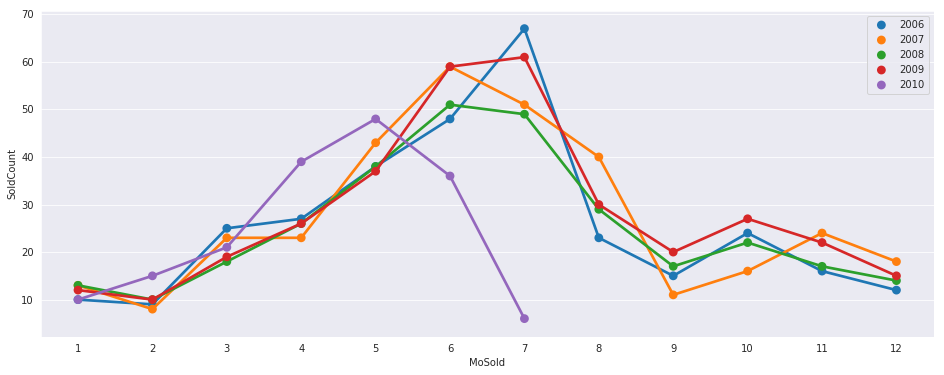

In [23]:
grp = train.groupby(['YrSold','MoSold'])
piv = grp.count()['SalePrice'].reset_index()
piv.columns = ['YrSold','MoSold','SoldCount']

plt.figure(figsize=(16, 6))
sns.pointplot(x='MoSold', y='SoldCount', hue='YrSold', data=piv, join=True)
plt.legend(loc='best')

all_data['_SaleSeason'] = all_data['MoSold'].replace({1:0, 2:0, 3:1, 4:1, 5:2, 6:3, 7:3, 8:2, 9:0, 10:1, 11:0, 12:0})


## Encode and transform

In [24]:
newest = all_data.YearBuilt.max()
oldest = all_data.YearBuilt.min()
age_range = newest - oldest
count_range = len(all_data.YearBuilt.unique())
print(age_range, count_range)

138 118


In [25]:
# year feature
cols = ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']
print(all_data[cols].describe())

# relation feature
all_data['_Remod_Sold'] = 0
all_data.loc[all_data['YrSold'] <= all_data['YearRemodAdd'], '_Remod_Sold'] = 1
all_data['_Built_Sold'] = 0
all_data.loc[all_data['YrSold'] <= all_data['YearBuilt'], '_Built_Sold'] = 1

# year group
bins = np.linspace(all_data.YearBuilt.min(), all_data.YearBuilt.max(), 10)
labels = range(len(bins) - 1)
all_data['_YearBuiltGrp'] = pd.cut(all_data.YearBuilt, bins=bins, labels=labels)
all_data._YearBuiltGrp.map({0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 7:7, 8:8})

# diff feature
all_data['_YrBlt_to_sold'] = all_data['YrSold'] - all_data['YearBuilt']
all_data['_YrRemod_to_sold'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['_GrgYrBlt_to_sold'] = all_data['YrSold'] - all_data['GarageYrBlt']

            YrSold    YearBuilt  YearRemodAdd  GarageYrBlt
count  2919.000000  2919.000000   2919.000000  2919.000000
mean   2007.792737  1971.312778   1984.264474  1976.203152
std       1.314964    30.291442     20.894344    26.679966
min    2006.000000  1872.000000   1950.000000  1872.000000
25%    2007.000000  1953.500000   1965.000000  1959.000000
50%    2008.000000  1973.000000   1993.000000  1978.000000
75%    2009.000000  2001.000000   2004.000000  2001.000000
max    2010.000000  2010.000000   2010.000000  2010.000000


In [0]:
# to categorical feature
cols = ['MSSubClass']
for c in cols:
    all_data[c] = all_data[c].astype(str)

#log transform skewed numeric features
numeric_feats = all_data.drop('SalePrice', axis=1).dtypes[all_data.dtypes != "object"].index
skewed = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats = skewed[skewed > 1].index

for c in (skewed_feats):
    all_data[c] = np.log1p(all_data[c])

mssubclass_map = {'180':1, '30':2, '45':2, '190':3, '50':3, '90':3, '85':4, '40':4, '160':4, 
                  '70':5, '20':5, '75':5, '80':5, '150':5, '120':6, '60':6}
all_data['_MSSubClassBin'] = all_data['MSSubClass'].map(mssubclass_map)

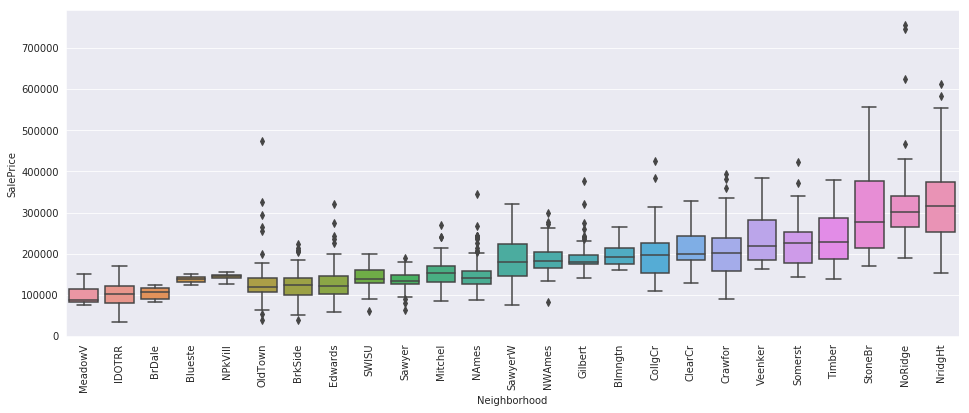

In [27]:
neighborhood_map = {
        "MeadowV":0, "IDOTRR":0, "BrDale":0, 
        "Blueste":1, "NPkVill":1, "OldTown":1,
        "BrkSide":2, "Edwards":2,
        "SWISU":3, "Sawyer":3,
        "Mitchel":4, "NAmes":4, 
        "SawyerW":5, "NWAmes":5, 
        "Gilbert":6, "Blmngtn":6, 
        "CollgCr":7, "ClearCr":7, "Crawfor":7, 
        "Veenker":8, "Somerst":8, "Timber":8, 
        "StoneBr":9, "NoRidge":9, "NridgHt":9,
}
all_data["_NeighborhoodBin"] = all_data["Neighborhood"].map(neighborhood_map)

plt.figure(figsize=(16, 6))
ax = sns.boxplot(x='Neighborhood', y='SalePrice', data=all_data[all_data['SalePrice'].notnull()], order=neighborhood_map.keys())
_=ax.set_xticklabels(ax.get_xticklabels(), rotation='vertical')

In [0]:
# encode quality - Ex(Excellent), Gd（Good）, TA（Typical/Average）, Fa（Fair）, Po（Poor）
all_data.loc[(all_data['PoolArea'] > 0) & (all_data['PoolQC'] == 'None'), 'PoolQC'] = 'TA'
cols = ['ExterQual','ExterCond','BsmtQual','BsmtCond','HeatingQC','KitchenQual','FireplaceQu','GarageQual','GarageCond','PoolQC']
for c in cols:
    all_data[c].replace({'None':0, 'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}, inplace=True)

# encode remaining columns
all_data['BsmtExposure'].replace({'Gd':4,'Av':3,'Mn':2,'No':1,'None':0}, inplace=True)
all_data['CentralAir'].replace({'Y':1,'N':0}, inplace=True)
all_data['GarageFinish'].replace({'Fin':3,'RFn':2,'Unf':1,'None':0}, inplace=True)
all_data['Utilities'].replace({'AllPub':3,'NoSewr':2,'NoSeWa':1,'ELO':0}, inplace=True)
all_data['LandSlope'].replace({'Gtl':2,'Mod':1,'Sev':0}, inplace=True)
all_data['Functional'].replace({'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal':0}, inplace=True)
all_data['LotShape'].replace({'Reg':3,'IR1':2,'IR2':1,'IR3':0}, inplace=True)

# encode to another 
all_data['_PriceCut'] = all_data['SaleCondition'].replace(
    {'AdjLand':1,'Abnorml':1,'Family':1,'Alloca':1,'Normal':0,'Partial':0})

In [29]:
# Condition1&2, Exterior1st&2nd --> merged dummies
def pair_features_to_dummies(df, col1, col2, prefix):
    d_1 = pd.get_dummies(df[col1].astype(str), prefix=prefix)
    d_2 = pd.get_dummies(df[col2].astype(str), prefix=prefix)
    for c in list(set(list(d_1.columns) + list(d_2.columns))):
        if not c in d_1.columns: d_1[c] = 0
        if not c in d_2.columns: d_2[c] = 0
    return (d_1 + d_2).clip(0, 1)

cond = pair_features_to_dummies(all_data,'Condition1','Condition2','Condition')
exterior = pair_features_to_dummies(all_data,'Exterior1st','Exterior2nd','Exterior')

all_data = pd.concat([all_data, cond, exterior], axis=1)
all_data.drop(['Condition1','Condition2','Exterior1st','Exterior2nd'], axis=1, inplace=True)
all_data.loc[:,cond.columns[0]:].head()

,Condition_Artery,Condition_Feedr,Condition_Norm,Condition_PosA,Condition_PosN,Condition_RRAe,Condition_RRAn,Condition_RRNe,Condition_RRNn,Exterior_AsbShng,...,Exterior_ImStucc,Exterior_MetalSd,Exterior_Other,Exterior_Plywood,Exterior_Stone,Exterior_Stucco,Exterior_VinylSd,Exterior_Wd Sdng,Exterior_Wd Shng,Exterior_WdShing
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [0]:
# Create new polynomial features about OverallQual
all_data['_TotalSF_OverallQual'] = all_data['_TotalSF'] * all_data['OverallQual']
all_data['_Neighborhood_OverallQual'] = all_data['_NeighborhoodBin'] + all_data['OverallQual']
all_data['_Functional_OverallQual'] = all_data['Functional'] + all_data['OverallQual']

for i, t in all_data.loc[:, all_data.columns != 'SalePrice'].dtypes.iteritems():
    if t == object:
        all_data = pd.concat([all_data, pd.get_dummies(all_data[i].astype(str), prefix=i)], axis=1)
        all_data.drop(i, axis=1, inplace=True)

all_data['GarageCars'] = all_data['GarageCars'].clip(0,3)

# This column is missing in the training data.
all_data.drop(["MSSubClass_150"], axis=1, inplace=True)

In [31]:
nan_info(all_data)

Unique dtypes: [dtype('int64') dtype('float64')
 CategoricalDtype(categories=Noneordered=True) dtype('uint8')]

NaN count per feature:
SalePrice        1459
_YearBuiltGrp       1
dtype: int64

Total elements in df: 823158

Null values in df: 1460

Percentage null values: 0.2%


### Feature Importance

In [0]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model

In [0]:
train = all_data[all_data['SalePrice'].notnull()]
test = all_data[all_data['SalePrice'].isnull()].drop('SalePrice', axis=1)

train = train.fillna(train.median())
test = test.fillna(test.median())

all_data = train.append(test, sort=False).reset_index(drop=True)

X_train = train.drop(['SalePrice','Id'], axis=1)
y_train = train['SalePrice']
y_log = np.log1p(y_train)

In [34]:
nan_info(train)

Unique dtypes: [dtype('int64') dtype('float64')
 CategoricalDtype(categories=Noneordered=True) dtype('uint8')]

NaN count per feature:
Series([], dtype: int64)

Total elements in df: 411720

Null values in df: 0

Percentage null values: 0.0%


In [35]:
nan_info(test)

Unique dtypes: [dtype('int64') dtype('float64')
 CategoricalDtype(categories=Noneordered=True) dtype('uint8')]

NaN count per feature:
Series([], dtype: int64)

Total elements in df: 409979

Null values in df: 0

Percentage null values: 0.0%


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


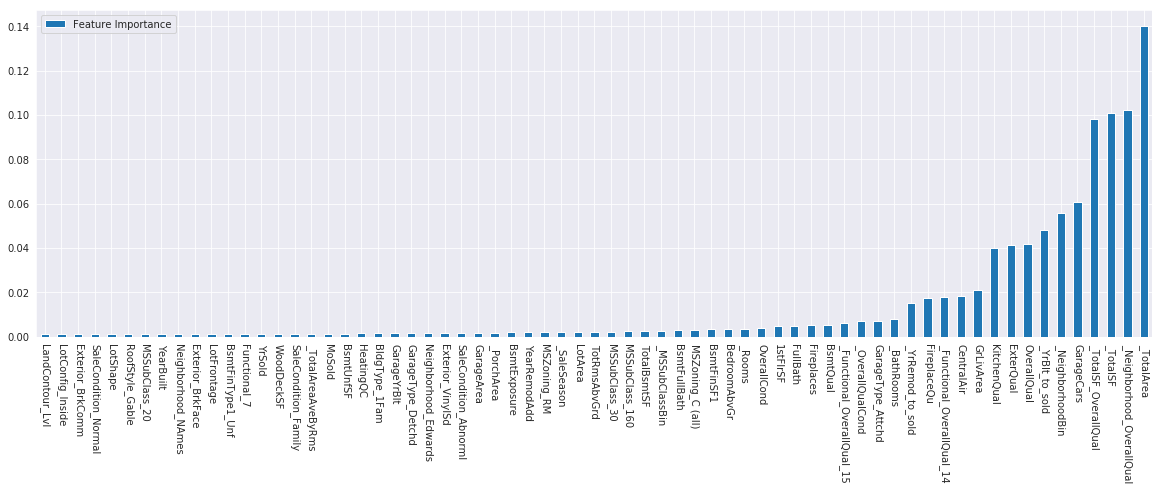

In [39]:
etr = ExtraTreesRegressor(n_jobs=nthreads)
etr.fit(X_train, y_log)
fi_etr = pd.DataFrame({"Feature Importance":etr.feature_importances_}, index=X_train.columns)
fi_etr = fi_etr[fi_etr["Feature Importance"] > 1e-3].sort_values("Feature Importance")
fi_etr.plot(kind="bar",figsize=(20,6))
fi_etr_values = fi_etr.index.values
plt.xticks(rotation=-90)
plt.show()

In [40]:
low_feature_importance_cols = fi_etr[abs(fi_etr["Feature Importance"]) < 1e-2].index.values
n_low_fi_cols = len(low_feature_importance_cols)
n_low_fi_cols

52

## Preparation

In [0]:
train = all_data[all_data['SalePrice'].notnull()]
test = all_data[all_data['SalePrice'].isnull()].drop('SalePrice', axis=1)

X_train = train.drop(['SalePrice','Id'], axis=1)
X_train = X_train.fillna(X_train.median())

X_test  = test.drop(['Id'], axis=1)
X_test = X_test.fillna(X_test.median())

In [0]:
from sklearn import ensemble, metrics
from sklearn import linear_model, preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.kernel_ridge import KernelRidge

In [0]:
scaler = preprocessing.RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X = X_train_scaled

## Model

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models, weight):
        self.models = models
        self.weight = weight
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        predictions = np.column_stack([(model.predict(X) * weight) for model, weight in zip(self.models_, self.weight)])
        return np.sum(predictions, axis=1)

In [0]:
cv = 3

In [0]:
kr_param_dist = {'alpha': uniform(1e-4, 1e-1),
                 'gamma': uniform(1e-3, 1.0),
                 'coef0': uniform(1e-2, 10.0)}

n_iter_search = 500

kr = KernelRidge(kernel='rbf')

kreg = RandomizedSearchCV(kr, param_distributions=kr_param_dist,
                          n_iter=n_iter_search, cv=cv,
                          n_jobs=nthreads, verbose=1)

kreg.fit(X, y_log)

kr_params = kreg.best_params_
kr_params['kernel'] = 'rbf'

krr = KernelRidge(**kr_params)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [0]:
lasso_param_dist = {'alpha': uniform(5e-4, 1e-1),
                    'random_state': randint(0,100)}

n_iter_search = 500

lasso = linear_model.Lasso(max_iter=1e4)

lsoreg = RandomizedSearchCV(lasso, param_distributions=lasso_param_dist,
                          n_iter=n_iter_search, cv=cv,
                          n_jobs=nthreads, verbose=1)

lsoreg.fit(X, y_log)

lasso_params = lsoreg.best_params_

lasso = linear_model.Lasso(**lasso_params)
lasso_params

In [0]:
train_gb = True
if train_gb:
    gb_param_dist = {'learning_rate': uniform(1e-3, 1e-1),
                      'max_depth': randint(3, 6),
                      'max_features': uniform(0, 0.8),
                      'min_samples_leaf': randint(4, 10)}

    n_iter_search = 200

    gb = ensemble.GradientBoostingRegressor(n_estimators=1000)

    gbreg = RandomizedSearchCV(gb, param_distributions=gb_param_dist,
                               n_iter=n_iter_search, cv=cv,
                               n_jobs=nthreads, verbose=1)

    gbreg.fit(X, y_log)

    gb_params = gbreg.best_params_
    gb_params['n_estimators'] = 4000
    gb_params['random_state'] = 82
else:
    gb_params = {'learning_rate': 0.02,
                 'max_depth': 3,
                 'max_features': 0.126,
                 'min_samples_leaf': 4,
                 'n_estimators': 4000,
                 'random_state': 82}

gboost = ensemble.GradientBoostingRegressor(**gb_params)
gb_params

In [0]:
reg = AveragingModels(models=(krr, lasso, gboost), weight=[0.30, 0.30, 0.40])

In [0]:
def rmse_cv(model, x, y):
    rmse = np.sqrt(-cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=cv))
    return rmse

In [0]:
score = rmse_cv(reg, X, y_log)
print(f'{score.mean():.5f}')

## Prediction

In [0]:
reg.fit(X, y_log)
result = np.expm1(reg.predict(X_test_scaled))

In [0]:
submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": result
})
submission.to_csv(os.path.join(submission_path, f'submission_{time_now()}.csv'), index=False)

In [0]:
submission.head(10)